In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
import matplotlib.pyplot as plt

# always import gbm_algos first !
import xgboost, lightgbm, catboost

# Core
import numpy as np
import scipy.io as io
from torch.autograd import grad
from torch.utils.data import DataLoader, Dataset

# Sklearn
from sklearn.ensemble import RandomForestRegressor
from mlens.ensemble import SuperLearner

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew
# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder
from onecyclelr import OneCycleLR
import pcgrad
from pytorch_stats_loss import torch_wasserstein_loss, torch_energy_loss
from geomloss import SamplesLoss
from utils import *

from tqdm import trange

[MLENS] backend: threading


[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [2]:
DATA_PATH = "/Users/pongpisit/Desktop/research/pinn/Solving-Differential-Equations-with-Neural-Networks/SymbolicMathematics/data/burgers_shock.mat"
data = io.loadmat(DATA_PATH)

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

N = 500
print(f"Training with {N} samples")
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx,:]

# Unsup data
N_res = N//2
idx_res = np.array(range(X_star.shape[0]-1))[~idx]
idx_res = np.random.choice(idx_res.shape[0], N_res, replace=True)
X_res = X_star[idx_res, :]
print(f"Training with {N_res} unsup samples")
X_u_train = np.vstack([X_u_train, X_res])
u_train = np.vstack([u_train, torch.rand(X_res.shape[0], 1) - 1000])
# del X_res

# Convert to torch.tensor
X_u_train = torch.tensor(X_u_train).float().requires_grad_(True)
u_train = torch.tensor(u_train).float().requires_grad_(True)
X_star = torch.tensor(X_star).float().requires_grad_(True)
u_star = torch.tensor(u_star).float().requires_grad_(True)
# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)
feature_names=['uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx']

Training with 500 samples
Training with 250 unsup samples


In [3]:
class Network(nn.Module):
    def __init__(self, model):
        super(Network, self).__init__()
        # pls init the self.model before
        self.model = model
        # For tracking
        self.index2features = ('uf', 'u_x',  'u_xx', 'u_tt', 'u_xt', 'u_tx')
        self.uf = None
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        self.uf = self.model(torch.cat([x, t], dim=1))
        return self.uf
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        
        ### PDE Loss calculation ###
        # first-order derivatives
        u_t = self.gradients(uf, t)[0]
        u_x = self.gradients(uf, x)[0]
        # Homo second-order derivatives
        u_tt = self.gradients(u_t,t)[0]
        u_xx = self.gradients(u_x, x)[0]
        # Hetero second-order derivatives
        u_xt = self.gradients(u_t, x)[0]
        u_tx = self.gradients(u_x, t)[0]
        
        X_selector = torch.cat([uf, u_x, u_xx, u_tt, u_xt, u_tx], dim=1)
        y_selector = u_t
        
        return X_selector, y_selector
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

In [4]:
# Does the SeclectorNetwork has to be a neural networks ???
class SeclectorNetwork(nn.Module):
    def __init__(self, X_train_dim, bn=None):
        super().__init__()
        # Nonlinear model, Training with PDE reg.
        self.nonlinear_model = TorchMLP(dimensions=[X_train_dim, 50, 50, 1], activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1), inp_drop=False)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn):
        ut_approx = self.nonlinear_model(inn)
        return ut_approx
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        return mse_loss

class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
    def forward(self, X_u_train):
        X_selector, y_selector = self.network.get_selector_data(*dimension_slicing(X_u_train))
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        unsup_loss = self.selector.loss(X_selector, y_selector)
        return self.network.uf, unsup_loss

In [6]:
# network = Network(model=TorchMLP(dimensions=[6, 50, 50, 50 ,50, 50, 1], bn=nn.BatchNorm1d))
# selector = SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm)

### Version without normalized derivatives ###
# semisup_model = SemiSupModel(network=Network(model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], activation_function=nn.Tanh, bn=nn.LayerNorm, dropout=None)),
#                              selector=SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm),
#                              normalize_derivative_features=False, 
#                              mini=None, 
#                              maxi=None)

### Version with normalized derivatives ###
pretrained_state_dict = torch.load('./saved_path_inverse_burger/lbfgsnew_results/semisup_model_with_LayerNormDropout_without_physical_reg_trained500labeledsamples_trained0unlabeledsamples_9.1e-04.pth')
network_state_dict = None
is_pretrained = True
semisup_model = SemiSupModel(network=Network(model=TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], activation_function=nn.Tanh, bn=nn.LayerNorm, dropout=None)),
                             selector=SeclectorNetwork(X_train_dim=6, bn=nn.LayerNorm),
                             normalize_derivative_features=True, 
                             mini=None, 
                             maxi=None)
if is_pretrained:
    print("Use pretrained weights")
    semisup_model.load_state_dict(pretrained_state_dict)
    network_state_dict = semisup_model.network.state_dict()
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Use pretrained weights


In [7]:
def pcgrad_closure():
    global N, X_u_train, u_train
    uf, unsup_loss = semisup_model(X_u_train)
    losses = [F.mse_loss(uf[:N, :], u_train), unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    return sum(losses)

def closure():
    global N, X_u_train, u_train
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_u_train))[:N, :], u_train)
    if mse_loss.requires_grad:
        mse_loss.backward(retain_graph=False)
    return mse_loss

Learning rate finding


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.92E-07


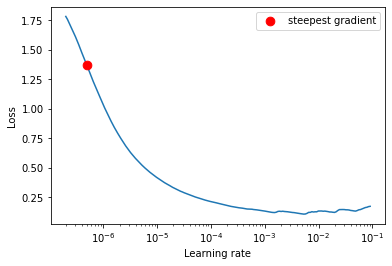

Deleted the fake labels used in Learning rate finder


In [8]:
params = semisup_model.parameters()

### For SGD and Adam ###
learning_rate1, learning_rate2 = 1e-7, 1e-1

### For LBFGS (a good choice already!!!) ###
# print("Using LBFGS's learning rate set")
# learning_rate1, learning_rate2 = 8e-2, 5e-2 # (1e-1, 5e-2) is also OK!

choice = 'MAD'; auto_lr = True
if choice == 'LBFGS':
    optimizer1 = torch.optim.LBFGS(params, lr=learning_rate1, 
                                   max_iter=100, max_eval=125, 
                                  history_size=120, line_search_fn='strong_wolfe')
if choice == 'Adam':
    optimizer1 = AdamGC(params, lr=learning_rate1, use_gc=True, gc_conv_only=False, gc_loc=False)
if choice == 'SGD':
    optimizer1 = SGDGC(params, lr=learning_rate1, use_gc=True, nesterov=True, momentum=0.95)
if choice == 'MAD':
    optimizer1 = MADGRAD(params, lr=learning_rate1, momentum=0.9)

if choice != 'LBFGS' and auto_lr:
    print('Learning rate finding')
    bs = 4000; bs = X_u_train.shape[0] if bs>X_u_train.shape[0] else bs
    criterion = LadderLoss(return_list=True)
    trainloader = get_dataloader(X_u_train, u_train, bs=bs)
    
    lr_finder = LRFinder(semisup_model, optimizer=optimizer1, 
                         closure=pcgrad_update, criterion=criterion, device="cpu")
    lr_finder.range_test(trainloader, val_loader=None, end_lr=100, num_iter=300)
    
    # to inspect the loss-learning rate graph
    suggested_lr, _ = lr_finder.plot()
    # To prevent divergence during the second stage training.
    # suggested_lr = min(suggested_lr, 5e-3)
    lr_finder.reset(); plt.show()

else:
    lr_finder = None
    suggested_lr = None
    
print("Deleted the fake labels used in Learning rate finder")
u_train = u_train[:N, :]

In [9]:
# Set the learing_rate to the suggested one.
# suggested_lr = 1e-5

if lr_finder and suggested_lr:
    optimizer1 = lr_finder.optimizer

for g in optimizer1.param_groups:
    g['lr'] = suggested_lr

epochs1 = 300; epochs2 = 30000;

In [10]:
# Setting up the generator
generator = TorchMLP([2, 50, 50, 2])
# generator_training_epochs indicates how string the generator is
adv_f = 100; generator_training_epochs = 300; generator_training_limit = epochs1-100
# I can use the Learning rate finder to find a good lr for the generator optim  as well
generator_optimizer = torch.optim.SGD(generator.parameters(), lr=3e-4, momentum=0.95)
sinkhorn_loss = SamplesLoss("sinkhorn", p=2, blur=1.0)

### Experiments with the generator

In [11]:
curr_loss = 1000; F_print = 10 if choice == 'LBFGS' else 100

# Stage I
# How long should I pretrain selector part of the model?
for _ in range(1):
    # Reinit the semisup_model.network weights
    semisup_model.network.load_state_dict(network_state_dict)
    for i in range(epochs1):
        if i%adv_f==0 and i<=generator_training_limit:
            best_generator_loss = 1000; best_generator_state_dict = None
            o_tensor = X_u_train[:N, :] # or X_u_train ?
            print("Training the generator for ")
            for _ in trange(generator_training_epochs):
                semisup_model.eval()
                generator.train()
                generator_optimizer.zero_grad()
                X_gen = scale_to_range(generator(o_tensor), lb, ub)
                unsup_loss = semisup_model(X_gen)[1]
#                 d_loss = F.mse_loss(X_gen, o_tensor)
                d_loss = F.mse_loss(X_gen, o_tensor)
                generator_loss = d_loss-unsup_loss
                generator_loss.backward(retain_graph=True)
                generator_optimizer.step()
                # Saving the best_generator_state_dict
                if generator_loss.item() < best_generator_loss:
                    best_generator_loss = generator_loss.item()
                    best_generator_state_dict = generator.state_dict()

            print("The best generator loss:", best_generator_loss)
            generator.load_state_dict(best_generator_state_dict)
            generator.eval()
            X_gen = scale_to_range(generator(o_tensor), lb, ub)
            if N_res<X_gen.shape[0]: X_gen = sampling_from_rows(X_gen, N_res)
            X_u_train = torch.cat([X_u_train[:N, :], X_gen], dim=0).detach().requires_grad_(True)

        semisup_model.train()
        generator_optimizer.zero_grad()
        optimizer1.step(pcgrad_closure)
        l = pcgrad_closure()
        if (i % F_print) == 0:
            if l.item() != curr_loss:
                curr_loss = l.item()
            else:
                print("Semi-supervised solver loss @Epoch {}: ".format(i), curr_loss)
                print("Finishing the first stage")
                break
            print("Semi-supervised solver loss @Epoch {}: ".format(i), curr_loss)

  0%|          | 0/300 [00:00<?, ?it/s]

Training the generator for 


100%|██████████| 300/300 [00:22<00:00, 13.40it/s]


The best generator loss: -3.18418288230896
Semi-supervised solver loss @Epoch 0:  2.486341714859009


  1%|          | 2/300 [00:00<00:24, 11.94it/s]

Training the generator for 


100%|██████████| 300/300 [00:22<00:00, 13.28it/s]


The best generator loss: 0.5636008977890015
Semi-supervised solver loss @Epoch 100:  0.2007068693637848


  1%|          | 2/300 [00:00<00:24, 12.39it/s]

Training the generator for 


100%|██████████| 300/300 [00:22<00:00, 13.28it/s]


The best generator loss: 0.591063916683197
Semi-supervised solver loss @Epoch 200:  0.17796669900417328


In [12]:
optimizer2 = LBFGSNew(semisup_model.network.parameters(), 
                              lr=learning_rate2, max_iter=100, max_eval=125, 
                              history_size=120, line_search_fn=True, batch_mode=False)

# optimizer2 = torch.optim.LBFGS(semisup_model.network.parameters(), 
#                               lr=learning_rate2, max_iter=100, max_eval=125, 
#                               history_size=120, line_search_fn='strong_wolfe')

In [13]:
curr_loss = 1000
# Stage II
semisup_model.train()
for i in range(20000):
    optimizer2.step(closure)
    l = closure()
    if (i % 100) == 0:
        if l.item() != curr_loss:
            curr_loss = l.item()
        else:
            print("Finishing the second stage")
            break
        print("Epoch {}: ".format(i), curr_loss)

Epoch 0:  1.486625933466712e-06
Epoch 100:  9.273864520764619e-08
Epoch 200:  4.429161393204595e-08
Epoch 300:  2.4391203723439503e-08
Epoch 400:  1.7658988937796494e-08
Epoch 500:  1.1833122037785415e-08
Epoch 600:  8.283874031178584e-09
Epoch 700:  6.800862539790842e-09
Epoch 800:  5.8494107335604895e-09
Epoch 900:  4.669451492134158e-09
Epoch 1000:  4.314312906927853e-09
Epoch 1100:  3.824858207934767e-09
Epoch 1200:  3.5138525422695466e-09
Epoch 1300:  3.1004705469683813e-09
Epoch 1400:  2.7930939783260555e-09
Epoch 1500:  2.55351340072707e-09
Epoch 1600:  2.418030442541408e-09
Epoch 1700:  2.2021167112029616e-09
Epoch 1800:  2.1949286832523285e-09
Epoch 1900:  1.9732391276505723e-09
Epoch 2000:  1.7952728192938139e-09
Epoch 2100:  1.7337667967964876e-09
Epoch 2200:  1.7274645047749004e-09
Epoch 2300:  1.6944902148097185e-09
Epoch 2400:  1.590238274395972e-09
Epoch 2500:  1.5799428432217155e-09
Epoch 2600:  1.5783752083109448e-09
Epoch 2700:  1.5797912977788542e-09
Epoch 2800:  1.5

In [16]:
print("Testing")
semisup_model.network.eval()
# Compare btw the two semi-supervise learning?
test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
string_test_performance = scientific2string(test_performance)
print('Test MSE:', string_test_performance)

Testing
Test MSE: 1.2e-05


In [17]:
# BEST-2000: 1e-06 (LBFGS)
# For saving the plain neural networks.
print("Saving")
MODEL_PATH = './saved_path_inverse_burger/lbfgsnew_results/semisup_model_with_LayerNormDropout_without_physical_reg_trained500labeledsamples_trained250unlabeledsamples_'+string_test_performance+'.pth'
torch.save(semisup_model.state_dict(), MODEL_PATH)

# torch.save(semisup_model.state_dict(), "./saved_path_inverse_burger/semisup_model_with_LayerNormDropout_without_physical_reg_trained2000labeledsamples_trained1000unlabeledsamples.pth")

Saving


In [16]:
# Loading the best model and testing
# semisup_model.load_state_dict(torch.load(MODEL_PATH), strict=False)
# semisup_model.eval()
# F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star)

In [17]:
# derivatives_test, dynamics_test = semisup_model.network.get_selector_data(*dimension_slicing(X_star))
# derivatives_train, dynamics_train = semisup_model.network.get_selector_data(*dimension_slicing(X_u_train))

# derivatives_test, dynamics_test = to_numpy(derivatives_test), to_numpy(dynamics_test)
# derivatives_train, dynamics_train = to_numpy(derivatives_train), to_numpy(dynamics_train)

# np.save("./saved_path_inverse_burger/lbfgsnew_results/data/derivatives-2000-V1.npy", derivatives_train)
# np.save("./saved_path_inverse_burger/lbfgsnew_results/data/dynamics-2000-V1.npy", dynamics_train)
# np.save("./saved_path_inverse_burger/lbfgsnew_results/data/derivatives-25600-V1.npy", derivatives_test)
# np.save("./saved_path_inverse_burger/lbfgsnew_results/data/dynamics-25600-V1.npy", dynamics_test)

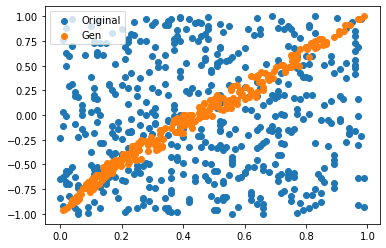

In [18]:
original_samples = to_numpy(X_u_train[:N, :])
generated_samples = to_numpy(X_gen)
x = original_samples[:, 0:1]
t = original_samples[:, 1:2]
x_g = generated_samples[:, 0:1]
t_g = generated_samples[:, 1:2]
plt.scatter(t, x, label='Original')
plt.scatter(t_g, x_g, label='Gen')
plt.legend()
plt.show()